In [1]:
# load packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests

# Load Data

In [2]:
df = pd.read_csv('DNA_sequences.csv')
sequences = df['Sequences']
labels = df['labels']

In [3]:
# use one-hot encoding to get each DNA sequence in the form of a matrix
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# The LabelEncoder encodes a sequence of bases as a sequence of integers.
integer_encoder = LabelEncoder()
# The OneHotEncoder converts an array of integers to a sparse matrix where
# each row corresponds to one possible value of each feature.
one_hot_encoder = OneHotEncoder(categories='auto')
input_features = []

for sequence in sequences:
    integer_encoded = integer_encoder.fit_transform(list(sequence))
    integer_encoded = np.array(integer_encoded).reshape(-1, 1)
    one_hot_encoded = one_hot_encoder.fit_transform(integer_encoded)
    input_features.append(one_hot_encoded.toarray())

np.set_printoptions(threshold=40)
input_features = np.stack(input_features)
print("Example sequence\n-----------------------")
print('DNA Sequence #1:\n',sequences[0][:10],'...',sequences[0][-10:])
print('One hot encoding of Sequence #1:\n',input_features[0].T)


Example sequence
-----------------------
DNA Sequence #1:
 CCGAGGGCTA ... CGCGGACACC
One hot encoding of Sequence #1:
 [[0. 0. 0. ... 1. 0. 0.]
 [1. 1. 0. ... 0. 1. 1.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [4]:
# use one-hot encoding to encode the labels
one_hot_encoder = OneHotEncoder(categories='auto')
labels = np.array(labels).reshape(-1, 1)
input_labels = one_hot_encoder.fit_transform(labels).toarray()

print('Labels:\n',labels.T)
print('One-hot encoded labels:\n',input_labels.T)

Labels:
 [[0 0 0 ... 0 1 1]]
One-hot encoded labels:
 [[1. 1. 1. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 1.]]


In [5]:
# split the data into training and test sets
# partition the training set into a training and validation set.
from sklearn.model_selection import train_test_split

train_features, test_features, train_labels, test_labels = train_test_split(
    input_features, input_labels, test_size=0.25, random_state=42)

# Model Building and Evaluation

A Convolutional Neural Network containing an Attention Block was implemented. This model contains following layers:




1. Input Layer
2. Convolutional layer
3. Maxpooling layer
4. Convolutional layer
5. Max pooling layer
6. LSTM
7. AttentionBlock
8. Global max pooling layer
9. Dense layer
10. Dropour layer
11. Output layer (dense)






**Convolutional Neural Network with an Attention block**


In [16]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, LSTM, Bidirectional, Dense, Dropout, Flatten, LayerNormalization, Permute, TimeDistributed, GlobalMaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping

class SelfAttention2D(tf.keras.layers.Layer):
    def __init__(self, attention_units):
        super(SelfAttention2D, self).__init__()
        self.attention_units = attention_units

    def build(self, input_shape):
        self.W_q = self.add_weight(name='W_q',
                                  shape=(input_shape[-1], self.attention_units),
                                  initializer='uniform',
                                  trainable=True)
        self.W_k = self.add_weight(name='W_k',
                                  shape=(input_shape[-1], self.attention_units),
                                  initializer='uniform',
                                  trainable=True)
        self.W_v = self.add_weight(name='W_v',
                                  shape=(input_shape[-1], self.attention_units),
                                  initializer='uniform',
                                  trainable=True)

    def call(self, inputs):
        Q = tf.matmul(inputs, self.W_q)
        K = tf.matmul(inputs, self.W_k)
        V = tf.matmul(inputs, self.W_v)

        attention_logits = tf.matmul(Q, K, transpose_b=True)
        attention_scores = tf.nn.softmax(attention_logits, axis=-1)

        attention_output = tf.matmul(attention_scores, V)
        return attention_output

def create_binding_prediction_model(sequence_length, input_dim, num_classes):
    
    input_sequence = Input(shape=(sequence_length, input_dim, 1), name='input_sequence')

    conv2d_1 = Conv2D(filters=64, kernel_size=(10, 1), activation='relu')(input_sequence)
    maxpool2d_1 = MaxPooling2D(pool_size=(2, 1))(conv2d_1)
    conv2d_2 = Conv2D(filters=128, kernel_size=(5, 1), activation='relu')(maxpool2d_1)
    maxpool2d_2 = MaxPooling2D(pool_size=(2, 1))(conv2d_2)

    permuted = Permute((2, 1, 3))(maxpool2d_2)

    lstm1 = TimeDistributed(Bidirectional(LSTM(64, return_sequences=True)))(permuted)

    attention = SelfAttention2D(attention_units=32)(lstm1)


    flatten = Flatten()(attention)
    dense1 = Dense(64, activation='relu')(flatten)
    dropout = Dropout(0.5)(dense1)

    output = Dense(2, activation='sigmoid', name='output')(dropout)

    model = tf.keras.Model(inputs=input_sequence, outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

sequence_length = 50
input_dim = 4
num_classes = 1
input_data = tf.keras.layers.Input(shape=(sequence_length, input_dim, 1))
attention_model = create_binding_prediction_model(sequence_length, input_dim, num_classes)
attention_model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_sequence (InputLayer  [(None, 50, 4, 1)]        0         
 )                                                               
                                                                 
 conv2d_8 (Conv2D)           (None, 41, 4, 64)         704       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 20, 4, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 16, 4, 128)        41088     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 8, 4, 128)         0         
 g2D)                                                            
                                                           

**Training the model**

In [17]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = attention_model.fit(train_features, train_labels, batch_size=20, epochs=20, validation_split=0.2,  callbacks=[early_stopping])

Epoch 1/20
60/60 [==============================] - 6s 45ms/step - loss: 0.6893 - accuracy: 0.5467 - val_loss: 0.6449 - val_accuracy: 0.7567
Epoch 2/20
60/60 [==============================] - 2s 28ms/step - loss: 0.4809 - accuracy: 0.8008 - val_loss: 0.1796 - val_accuracy: 0.9433
Epoch 3/20
60/60 [==============================] - 2s 27ms/step - loss: 0.1987 - accuracy: 0.9425 - val_loss: 0.0988 - val_accuracy: 0.9900
Epoch 4/20
60/60 [==============================] - 2s 28ms/step - loss: 0.0432 - accuracy: 0.9892 - val_loss: 0.0274 - val_accuracy: 0.9967
Epoch 5/20
60/60 [==============================] - 2s 28ms/step - loss: 0.0049 - accuracy: 0.9992 - val_loss: 0.0025 - val_accuracy: 1.0000
Epoch 6/20
60/60 [==============================] - 2s 27ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.0077 - val_accuracy: 0.9967
Epoch 7/20
60/60 [==============================] - 2s 40ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.0299 - val_accuracy: 0.9967
Epoch 8/20
60

**Testing the model**

In [18]:
test_loss, test_accuracy = attention_model.evaluate(test_features, test_labels)

16/16 [==============================] - 1s 13ms/step - loss: 0.0017 - accuracy: 1.0000


Text(0.5, 0, 'epoch')

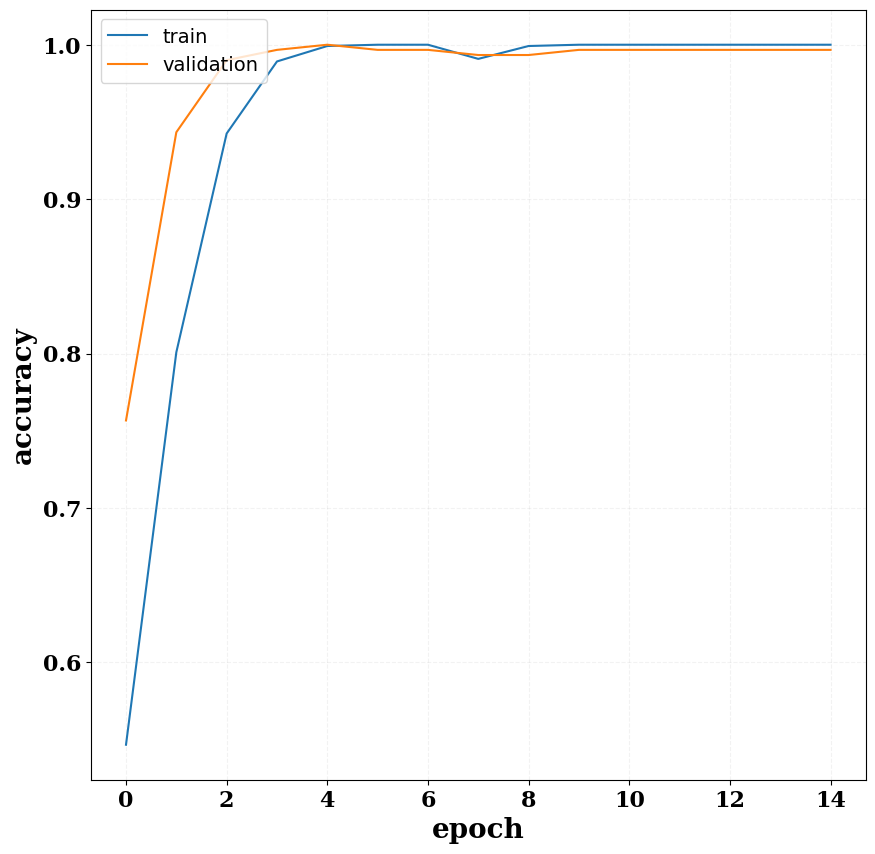

In [19]:
fig, ax = plt.subplots(figsize=(10, 10), dpi = 100)
plt.grid(color='gray', alpha=0.1, linestyle='--')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xticks(fontsize=16, fontweight='bold', fontfamily='serif')
plt.yticks( fontsize=16, fontweight='bold', fontfamily='serif')
plt.legend(['train', 'validation'], loc='upper left', fontsize=14)

plt.ylabel('accuracy', fontsize=20, fontweight='bold', fontfamily='serif')
plt.xlabel('epoch', fontsize=20, fontweight='bold', fontfamily='serif')

Text(0.5, 0, 'epoch')

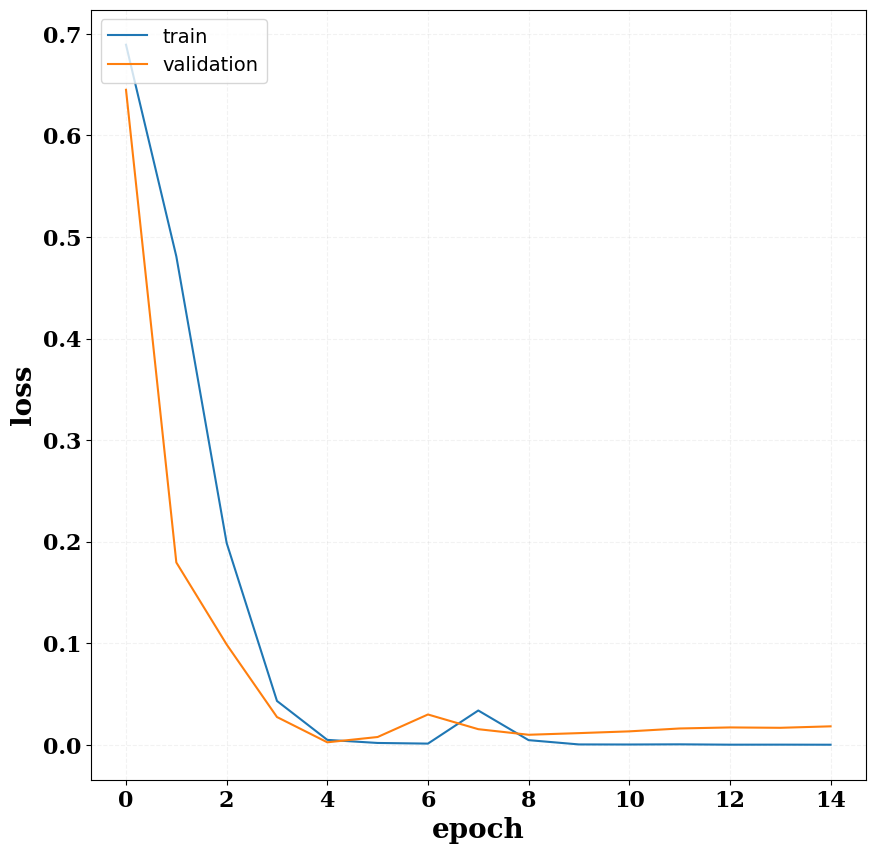

In [20]:
fig, ax = plt.subplots(figsize=(10, 10), dpi = 100)
plt.grid(color='gray', alpha=0.1, linestyle='--')

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train', 'validation'], loc='upper left', fontsize=14)

plt.xticks(fontsize=16, fontweight='bold', fontfamily='serif')
plt.yticks( fontsize=16, fontweight='bold', fontfamily='serif')
plt.ylabel('loss', fontsize=20, fontweight='bold', fontfamily='serif')
plt.xlabel('epoch', fontsize=20, fontweight='bold', fontfamily='serif')

16/16 [==============================] - 1s 12ms/step


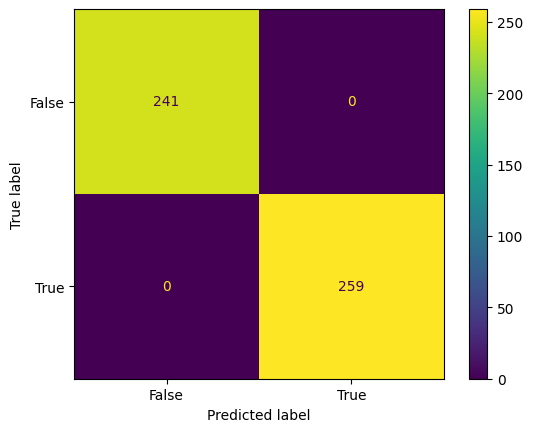

In [21]:
from sklearn import metrics
import keras
predictions = attention_model.predict(test_features)
test_pred_cat = np.argmin(predictions, axis=-1)
test_labels_cat = np.argmin(test_labels, axis=1)
cm = metrics.confusion_matrix(test_labels_cat, test_pred_cat, labels = [0, 1])
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = [False, True])
disp.plot()

In [23]:
import numpy as np

def identify_motifs_using_attention(model, sequence, motif_length=6, threshold=0.5):
    """
    Predict the potential short motifs that is the binding site in the sequences that are bound to the protein using the constructed Convolutional Neural Network model with an attention block.

    Args:
    - model: Trained Keras Convolutional Neural Network model with an attention block.
    - sequence: Input one-hot encoded DNA sequence.
    - motif_length: Max length of motifs to search for.
    - threshold: Activation threshold for selecting potential motifs.

    Returns:
    - List of identified motifs as strings.
    """
    sequence = np.expand_dims(sequence, axis=0)

    # we are interested in the output of the attention block
    intermediate_layer_model = tf.keras.Model(inputs=model.input, outputs=model.layers[-5].output)
    activations = intermediate_layer_model(sequence)

    activations_np = activations.numpy()
    flattened_activations = activations_np.flatten()

    potential_motif_indices = np.where(flattened_activations > threshold)[0]

    motifs = []
    for index in potential_motif_indices:
        start_index = max(0, index - motif_length // 2)
        end_index = min(len(sequence[0]) - 1, index + motif_length // 2)
        motif_sequence = sequence[0, start_index:end_index + 1]
        motif = ''.join(['A', 'C', 'G', 'T'][np.argmax(base)] for base in motif_sequence)
        if(len(motif) != 0):
              motifs.append(motif)

    return motifs

test_motifs = []
for i in range(len(test_features)):
        motifs = identify_motifs_using_attention(attention_model, test_features[i])
        print(motifs)
        test_motifs.append(motifs)


[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['AGGTGAA']
[]
[]
[]
[]
[]
[]
[]
[]
['TCCGCAC']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['CTTACAG']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['GGGCCAT']
[]
[]
[]
[]
['GAAGTCG']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['CCCTACT']
[]
[]
[]
[]
[]
[]
['TGTATTA']
[]
[]
[]
[]
[]
[]
[]
[]
['ACACCGT']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['TTTATTG']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['TAGTACC']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['CGTGGTT']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['CTTCTTA', 'TTCTTAG', 'AGCATAG', 'GCATAGC', 'AGTCTTC', 'CGACTAA', 'GACTAAA']
[]
['CGAACTC']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[

In [24]:
import numpy as np
import tensorflow as tf

In [25]:
def generate_saliency_map(model, input_data):
    """
    Generate a saliency map that can be used to identify potential motifs in a DNA sequence using a trained Keras Convolutional Neural Network model with an attention block.
    Args:
    - model (tf.keras.Model): A trained Keras Convolutional Neural Network model with an attention block.
    - input_data (numpy.ndarray): One-hot encoded DNA sequence for which the saliency map is to be generated.

    Returns:
    - numpy.ndarray: A saliency map highlighting regions of the input sequence that contribute significantly to the model's output.
    """
    input_tensor = tf.convert_to_tensor(input_data[np.newaxis, :], dtype=tf.float32)


    with tf.GradientTape() as tape:
        tape.watch(input_tensor)
        output = model(input_tensor)

    gradient = tape.gradient(output, input_tensor)

    saliency_map = tf.reduce_mean(tf.abs(gradient), axis=-1)

    return saliency_map

#generate saliency map for a random test sequence
saliency_map = generate_saliency_map(attention_model, test_features[4])

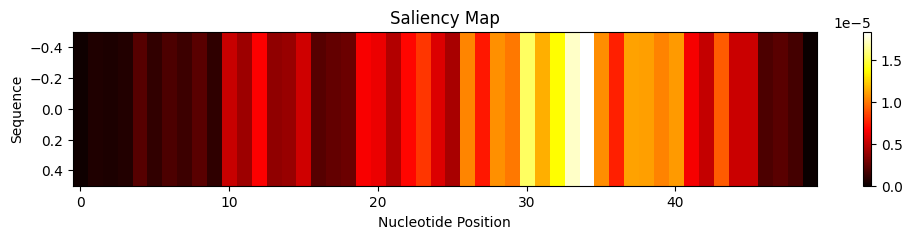

In [26]:
plt.figure(figsize=(12, 2))
plt.imshow(saliency_map, cmap='hot', aspect='auto')
plt.colorbar()
plt.title('Saliency Map')
plt.xlabel('Nucleotide Position')
plt.ylabel('Sequence')
plt.show()

In [29]:
from random import randint
import matplotlib.pylab as plt
import numpy as np
from keras.models import Sequential, Model

def get_feature_maps(model, layer_id, input_sequence):
    """
    This function retrieves the feature maps from a specific layer of the constructed neural network model when provided with an input sequence. It allows examining the representations learned by the neural network at a particular layer.

    Args:

    model: The neural network model from which to retrieve the feature maps.
    layer_id: The index of the layer in the model from which to obtain the feature maps.
    input_sequence: The input sequence for which feature maps are computed.
    Returns:

    A NumPy array containing the feature maps computed from the specified layer for the given input sequence. The array's dimensions are rearranged to follow the convention (channels, height, width).
    """
    model_ = Model(inputs=[model.input],
                   outputs=[model.layers[layer_id].output])
    return model_.predict(np.expand_dims(input_sequence,
                                         axis=0))[0,:,:,:].transpose((2,0,1))

def plot_features_map(seq_idx=None, layer_idx=[0, 1, 2, 3, 4, 5, 6, 7, 8],
                      x_test=test_features, ytest=test_labels, model=attention_model):
        """
        This function generates and displays a grid of feature maps from multiple layers of  the constructed neural network model. It aids in visualizing how the model's internal representations evolve as we move deeper into the network.

        Args:

        seq_idx : The index of the input sequence from the test dataset to visualize. If not provided, a random sequence index is selected.
        layer_idx : A list of layer indices for which feature maps should be plotted. By default, it includes the first 9 layers.
        x_test : The dataset containing input sequences (test features) to choose from when seq_idx is not specified.
        ytest : The corresponding labels or target values for the test dataset.
        model : The neural network model used for feature map extraction.
        Returns:

        The index of the selected or randomly chosen input sequence for reference.
        """
        if seq_idx == None:
            seq_idx = randint(0, ytest.shape[0])
        input_sequence = x_test[seq_idx]
        fig, ax = plt.subplots(3,3,figsize=(10,10))
        ax[0][0].imshow(input_sequence)
        ax[0][0].set_title('original img id {} - {}'.format(seq_idx, labels[int(ytest[seq_idx][0])]))
        for i, l in enumerate(layer_idx):
            feature_map = get_feature_maps(model, l, input_sequence)
            ax[(i+1)//3][(i+1)%3].imshow(feature_map[:,:,0])
            ax[(i+1)//3][(i+1)%3].set_title('layer {} - {}'.format(l, model.layers[l].name))
        return seq_idx

1/1 [==============================] - 1s 556ms/step


IndexError: ignored

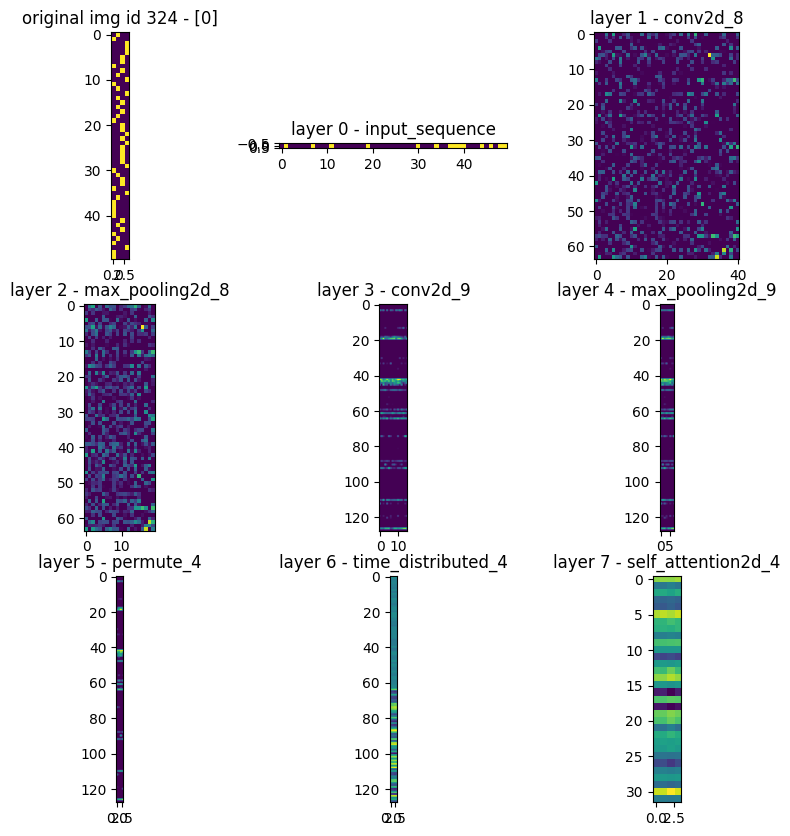

In [30]:
plot_features_map()